# Assessing the Predictive Validity of Qualitative Sensitivity Measures
This notebook replicates the analysis and the results of my master thesis.

# Contents



In [1]:
import os
import profile
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import chaospy as cp

from mpl_toolkits.mplot3d import Axes3D
from functools import partial
from joblib import Parallel, delayed # Drop if fct. for simulation of uncertainty propagation is taken to aux.
from ruspy.model_code.demand_function import get_demand # Drop if fct. for simulation of uncertainty propagation is taken to aux.

from python.morris import elementary_effects # Import from econsa if PR is through.
from python.shapley import get_shapley # Import from econsa if PR is through.
from python.auxiliary import rust_model_shapley
from python.auxiliary import rust_model_morris
from python.auxiliary import x_all_raw
from python.auxiliary import x_cond_raw
from python.auxiliary import simulate_cov_and_mean_rc_theta_11
from python.auxiliary import compute_confidence_intervals # Drop if replicates of Shapley effects is taken to aux.
from python.auxiliary import setup_rust_model_001 # Specs of Rust model.
from python.auxiliary import shapley_replicate
from python.auxiliary import shapley_convergence_n_outer
from python.auxiliary import descriptives_and_data_shapley_effects
from python.auxiliary import morris_convergence
from python.auxiliary import morris_replicate
from python.auxiliary import get_dataframes_morris_boxplots
from python.auxiliary import n_o

In [2]:
run_simulation_cov_mean = False # Done.
run_simulation_uncertainty_propagation = False # Done.
run_true_shapley = False # Done.
run_simulation_shapley_effects_convergence = False
run_simulation_shapley_effects_replicates = False # Done.
run_simulation_morris_indices_convergence = False
run_simulation_morris_indices_replicates = False # Done.
run_morris_3000 = False
n_cores = os.cpu_count()

## The Rust model
* Specs: why and what they mean.

In [3]:
model_setup = setup_rust_model_001()
params = model_setup['params']
ev = model_setup['ev']
costs = model_setup['costs']
trans_probs = model_setup['trans_probs']
trans_mat = model_setup['trans_mat']
init_dict_simulation = model_setup['init_dict_simulation']
init_dict_estimation = model_setup['init_dict_estimation']
demand_dict = model_setup['demand_dict']

* Simulate covariance matrix of inputs $RC$ and $\theta_{11}$.

In [4]:
%%time
# Simulation of 5,000 samples takes 3h 27min. (When using older version of the simulaton function.)
# Simulation of 10,000 samples takes 8h 33min 21s. (New version of function.)
num_sim = 10 ** 4
if run_simulation_cov_mean is True:
    cov, mean = simulate_cov_and_mean_rc_theta_11(num_sim, ev, costs, trans_mat, init_dict_simulation, init_dict_estimation)
    np.save(os.path.join('data', f'cov_rc_theta_11_{num_sim}'), cov)
    np.save(os.path.join('data', f'mean_rc_theta_11_{num_sim}'), mean)
elif run_simulation_cov_mean is False:
    cov = np.load(os.path.join('data', f'cov_rc_theta_11_{num_sim}.npy'))
    mean = np.load(os.path.join('data', f'mean_rc_theta_11_{num_sim}.npy'))
else:
    raise ValueError

Wall time: 8.99 ms


In [5]:
pd.DataFrame(data=cov, index= ['$RC$', '$\theta_{11}$'], columns=['$RC$', '$\theta_{11}$'])

,$RC$,$\theta_{11}$
$RC$,1.604736,0.605903
$\theta_{11}$,0.605903,0.273094


In [6]:
# cov_table = pd.DataFrame(data=cov, index= ['$RC$', '$\theta_{11}$'], columns=['$RC$', '$\theta_{11}$'])
# cov_table = cov_table.round(4)
# with open(os.path.join('figures', 'covariance_matrix.tex'),'w') as tf:
#     tf.write(cov_table.to_latex(escape=False)) # escape=False results into correct representation of RC and theta_11.

## Uncertainty propagation
How does the uncertainty in the inputs propagate to the output, implied annual demand?
Inspection of the distribution of the implied demand at certain $RC^{demand}$.

In [7]:
get_demand_partial = partial(get_demand, init_dict=init_dict_estimation, demand_dict=demand_dict)
def get_demand_mapping(x):
    return get_demand_partial(demand_params=x).iloc[0]['demand']

In [8]:
# Sample data.
num_sim_demand = 10 ** 5
input_variables = cp.MvNormal(params, cov).sample(num_sim_demand).T

In [9]:
demand_inputs = np.zeros((num_sim_demand, 5))
 # Trans prob.s stay the same.
demand_inputs[:, :3] = np.array([0.39189182, 0.59529371, 0.01281447])
demand_inputs[:, 3:] = input_variables[:, :]

In [10]:
%%time
# Use Joblib. 10 ** 4 runs take 30min 33s.
np.random.seed(123)
if run_simulation_uncertainty_propagation is True:
    implied_demand = Parallel(n_jobs=n_cores)(
            delayed(get_demand_mapping)(inp) for inp in demand_inputs
        )
    with open(os.path.join('data', f'implied_demand_{num_sim_demand}_runs.pickle'), 'wb') as handle:
        pickle.dump(implied_demand, handle)
else:
    with open(os.path.join('data', f'implied_demand_{num_sim_demand}_runs.pickle'), 'rb') as handle:
        implied_demand = pickle.load(handle)

Wall time: 183 ms


In [11]:
true_demand_params = np.concatenate((trans_probs, params))
true_implied_demand = get_demand(init_dict_estimation, demand_dict, true_demand_params).iloc[0]['demand']

In [12]:
implied_demand = np.asarray(implied_demand)

In [13]:
demand_empirical_distribution = pd.DataFrame(data=np.hstack((np.var(implied_demand), np.mean(implied_demand))), index=['Variance', 'Mean'], columns=[''])

In [14]:
demand_empirical_distribution

,
Variance,41.829977
Mean,58.666233


In [15]:
# demand_empirical_distribution.round(2)
# with open(os.path.join('figures', 'demand_empirical_distribution.tex'),'w') as tf:
#     tf.write(demand_empirical_distribution.to_latex(escape=False))

C:\Users\admin\anaconda3\envs\thesis-benedikt\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


[Text(0, 0.0, ''),
 Text(0, 0.01, ''),
 Text(0, 0.02, ''),
 Text(0, 0.03, ''),
 Text(0, 0.04, ''),
 Text(0, 0.05, ''),
 Text(0, 0.06, ''),
 Text(0, 0.07, '')]

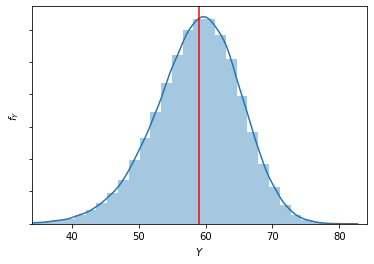

In [16]:
fig, ax = plt.subplots()
mpl.rcParams['font.family'] = 'serif'

sns.distplot(implied_demand)

ax.set_xlabel(r"$Y$")
ax.set_ylabel(r"$f_Y$")
dev_from_mean = 25
ax.set_xlim(left=true_implied_demand - dev_from_mean, right=true_implied_demand + dev_from_mean)

ax.axvline(x=true_implied_demand, ymin=0, ymax=1, color='red')

# ax.axvline(x=mean_implied_demand, ymin=0, ymax=1, color='grey')
ax.xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter("{x:,.0f}"))
ax.axes.get_yaxis().set_ticklabels([])

In [17]:
# Save to png.
# fig.savefig(fname=os.path.join('figures', f'uncertainty_propagation_{num_sim_demand}'), dpi=1000)

### Correletaion between $RC$ and $\theta_{11}$

In [18]:
n_correlation = 10 ** 4
rng = np.random.default_rng(123)
implied_demand_n_correlation = rng.choice(a=implied_demand, size=n_correlation)
input_variables_n_correlation = rng.choice(a=input_variables, size=n_correlation)

data_uncertainty_propagation = pd.DataFrame(np.hstack((input_variables_n_correlation, implied_demand_n_correlation.reshape(n_correlation, 1))), columns=['RC', 'theta_11', 'Y'])

Text(0, 0.5, '$\\theta_{11}$')

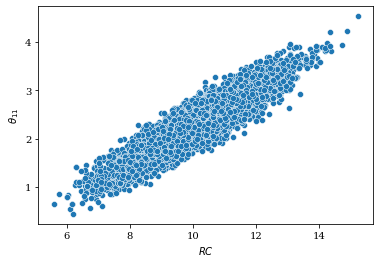

In [19]:
fig, ax = plt.subplots()
mpl.rcParams['font.family'] = 'serif'

sns.scatterplot(x=data_uncertainty_propagation['RC'], y=data_uncertainty_propagation['theta_11'])

ax.set_xlabel(r'$RC$')
ax.set_ylabel(r'$\theta_{11}$')

In [20]:
# Save to png.
fig.savefig(fname=os.path.join('figures', f'correlation_rc_theta'), dpi=1000)

In [21]:
# # 2d plots. Check whether 3d plots are 
# fig, ax = plt.subplots(3, 1, figsize=(10, 10))
# sns.scatterplot(x=data_uncertainty_propagation['RC'], y=data_uncertainty_propagation['Y'], ax=ax[0])
# sns.lineplot(x=data_uncertainty_propagation['theta_11'], y=data_uncertainty_propagation['Y'], ax=ax[1])
# sns.scatterplot(x=data_uncertainty_propagation['RC'], y=data_uncertainty_propagation['theta_11'], ax=ax[2])

# fig.tight_layout()
# # fig.show()

# Shapley effects

As a benchmark, I calculate Shapley effects for the Rust model (Rust 1987). To this end, I utilise the ruspy package (ref!) as well as the get_shapley method from the econsa package (ref!).

In [22]:
# Function inputs: mean and covariance matrix inputs.
n_inputs = 2
n_perms = None
np.random.seed(1234)

In [23]:
# Define model, and sampling functions.
model_shapley = partial(
    rust_model_shapley, trans_probs=trans_probs, init_dict_estimation=init_dict_estimation, demand_dict=demand_dict, 
)
x_all_partial = partial(x_all_raw, mean=params, cov=cov)
x_cond_partial = partial(x_cond_raw, mean=params, cov=cov)

### Finding the optimal $N_V$ (Number of MC runs used to estimate output variance).
For which values of $N_V$ does $V[Y]$ converge? Calculate $V[Y]$ for different numbers of Y. Use data simulated for uncertainty propagation.

In [24]:
n_output_variances = 100
output_variances = np.zeros(n_output_variances)
for i in np.arange(n_output_variances):
    k = (i + 1) * 10 ** 3
    output_variances[i] = np.var(implied_demand[0: k])

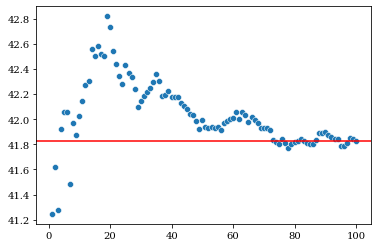

In [25]:
fig, ax = plt.subplots()
sns.set_theme(style='whitegrid')
ax = sns.scatterplot(x=np.arange(n_output_variances)+1, y=output_variances)

ax.axhline(y=np.var(implied_demand), xmin=0, xmax=n_output_variances, color='red')

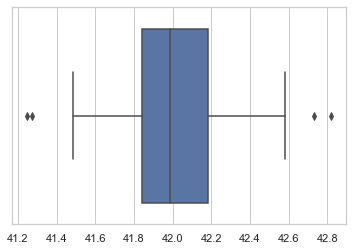

In [26]:
fig, ax = plt.subplots()
sns.set_theme(style='whitegrid')
ax = sns.boxplot(x=output_variances)

In [27]:
# Construct differently sized samples to get when N_V converges.
bins = np.array([0, 0.625, 1, 1.5, 3.125, 6.250, 12.5, 25, 50, 100])
output_variances_different_sizes = np.zeros(len(bins))
for i in np.arange(len(bins) - 1):
    k_lower = int(bins[i] * 10 ** 3)
    k_upper = int(bins[i + 1] * 10 ** 3)
    # print(f'[{k_lower}, {k_upper}]')
    output_variances_different_sizes[i] = np.var(implied_demand[k_lower: k_upper])
output_variances_different_sizes = output_variances_different_sizes[:len(bins) - 1]

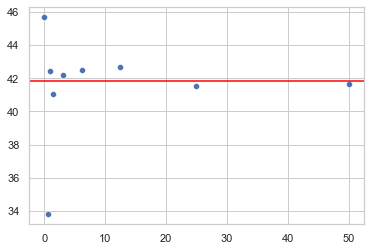

In [28]:
fig, ax = plt.subplots()
# sns.set_theme(style='whitegrid')
ax = sns.scatterplot(x=bins[:-1], y=output_variances_different_sizes)

ax.axhline(y=np.var(implied_demand), xmin=0, xmax=bins[-1], color='red')

# Convergence of Shapley effects - Compute Shapley effects for several values of $N_O$.
Do they converge for different values of $N_O$? For simplicity fix $N_V$ at specific level.

### Convergence and choice of $N_V$ and $N_O$

1. Fix a $N_V^1$ and see for which $N_O$ Shapley effects converge. Let $N_O^{conv,\ 1}$ denote this $N_O$ for which Shapley effects converge.

2. Fix $N_O^{conv,\ 1}$. Then decrease $N_V^1$ and see for which they are still converging. Let $N_V^2$ denote this $N_V$ for which Shapley effects converge.
    (No need to run `get_shapley` for this: can simply compute non-normalised Shapley effects by multiplying by $V[Y_{N_V^1}]$, and multiply by $V[Y_{\bar{N_V}}])$), $\bar{N_V}$ denoting a set of $N_V$ s.t. $N_V < N_V^1$.

3. Fix $N_V^2$ and see for which $N_O$ Shapley effects converge. Let $N_O^{conv,\ 2}$ denote this $N_O$ for which Shapley effects converge.

In [29]:
set_n_draws = np.array([100, 500, 1000, 1500, 2000])
computational_cost_morris = set_n_draws * 3 * n_inputs
computational_cost_morris

array([  600,  3000,  6000,  9000, 12000])

In [30]:
_n_variance = 10
for i in computational_cost_morris:
    print(n_o(i, _n_variance))

98.33333333333333
498.3333333333333
998.3333333333334
1498.3333333333333
1998.3333333333333


In [31]:
%%time
# Fix N_V, vary N_O.

set_n_outer = np.array([200, 500, 800, 1000, 2000, 3000, 4000, 6000])
# set_n_outer = np.array([200, 500, 800, 1000])
# set_n_outer = np.array([200, 500, 800, 1000]) took 33min 44s.
# set_n_outer = np.array([2000]) took 36min 51s.
# set_n_outer = np.array([3000, 4000, 6000]) took 3h 5min 51s.

n_variance = 10 ** 4
rng = np.random.default_rng(123)
output_variance = np.var(rng.choice(a=implied_demand, size=n_variance))

n_inner = 3

shapley_convergence_n_outer_partial = partial(shapley_convergence_n_outer, model_shapley, x_all_partial, x_cond_partial, n_perms, n_inputs, n_variance, n_inner, n_cores, output_variance)

np.random.seed(123)

if run_simulation_shapley_effects_convergence is True:
    shapley_effects_convergence_n_outer_01 = list(map(shapley_convergence_n_outer_partial, set_n_outer))
    with open(os.path.join('data', f'shapley_effects_convergence_{len(set_n_outer)}_runs_from_{set_n_outer[0]}_to_{set_n_outer[-1]}.pickle'), 'wb') as handle:
        pickle.dump(shapley_effects_convergence_n_outer_01, handle)
else:
    with open(os.path.join('data', f'shapley_effects_convergence_{len(set_n_outer)}_runs_from_{set_n_outer[0]}_to_{set_n_outer[-1]}.pickle'), 'rb') as handle:
        shapley_effects_convergence_n_outer_01 = pickle.load(handle)

Wall time: 18 ms


In [32]:
shapley_effects_convergence_n_outer_01

[               Shapley effects  std. errors    CI_min    CI_max
 $RC$                  0.402695     0.284748 -0.155412  0.960801
 $\theta_{11}$         0.597305     0.284748  0.039199  1.155412,
                Shapley effects  std. errors    CI_min    CI_max
 $RC$                  0.423393     0.299384 -0.163400  1.010186
 $\theta_{11}$         0.576607     0.299384 -0.010186  1.163400,
                Shapley effects  std. errors    CI_min    CI_max
 $RC$                  0.420418      0.29728 -0.162252  1.003088
 $\theta_{11}$         0.579582      0.29728 -0.003088  1.162252,
                Shapley effects  std. errors    CI_min    CI_max
 $RC$                   0.42231     0.298618 -0.162982  1.007602
 $\theta_{11}$          0.57769     0.298618 -0.007602  1.162982,
                Shapley effects  std. errors    CI_min    CI_max
 $RC$                  0.422897     0.299033 -0.163208  1.009003
 $\theta_{11}$         0.577103     0.299033 -0.009003  1.163208,
                Shap

In [33]:
def data_shapley_convergence(shapley_effects, set_n_outer):
    rc_shapley_effects = [
        shapley_effects[i]["Shapley effects"]["$RC$"] for i in np.arange(len(set_n_outer))
    ]
    theta_shapley_effects = [
        shapley_effects[i]["Shapley effects"]["$\theta_{11}$"]
        for i in np.arange(len(set_n_outer))
    ]

    # columns = ['shapley_effect']

    rc_shapley_effects_df = pd.DataFrame(data=rc_shapley_effects, columns=['rc'], index=set_n_outer)
    # rc_shapley_effects_df["input_variable"] = r"$RC$"
    # rc_shapley_effects_df['n_outer'] = set_n_outer

    theta_shapley_effects_df = pd.DataFrame(data=theta_shapley_effects, columns=['theta'], index=set_n_outer)
    # theta_shapley_effects_df["input_variable"] = r"$\theta_{11}$"
    # theta_shapley_effects_df['n_outer'] = set_n_outer

    data = pd.concat(
        [rc_shapley_effects_df, theta_shapley_effects_df], 
        # ignore_index=True,
        axis=1
    )
    # data.rename(columns={0: "shapley_effect"}, inplace=True)

    return data

In [34]:
shapley_convergence_df = data_shapley_convergence(shapley_effects_convergence_n_outer_01, set_n_outer)

In [35]:
shapley_convergence_df_plot = shapley_convergence_df.copy()
shapley_convergence_df_plot.columns = [r'$RC$', r'$\theta_{11}$']

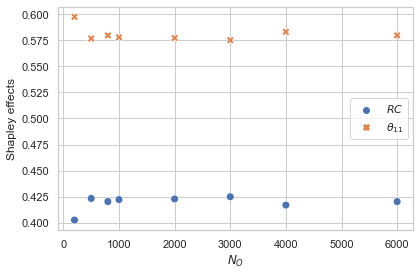

In [36]:
fig, ax = plt.subplots()
sns.set_theme(style='whitegrid')
mpl.rcParams['font.family'] = 'serif'

scatter = sns.scatterplot(data=shapley_convergence_df_plot,
markers=['o', 'X'],
legend=True,
s=60,
palette='deep'
)

ax.set(xlabel=r'$N_O$', ylabel='Shapley effects')

fig.tight_layout()

In [37]:
# fig.savefig(fname=os.path.join('figures', f'convergence_shapley_effects_{len(set_n_outer)}'), dpi=1000)

## Table Shapley convergence relative difference

In [38]:
# Get differences.
shapley_convergence_df_transposed = pd.DataFrame(data=shapley_convergence_df.T)

# abs_morr_diff = np.zeros(len(set_n_outer[:-1]))
rel_shapley_diff_rc = np.zeros(len(set_n_outer[:-1]))
rel_shapley_diff_theta = np.zeros(len(set_n_outer[:-1]))

# shapley_convergence_relative_difference = pd.DataFrame(data=np.zeros((2, len(set_n_outer[:-1]))), index=['rc', 'theta'], columns=set_n_outer[:-1])

for i in np.arange(len(set_n_outer[:-1])):
    delta = shapley_convergence_df_transposed[set_n_outer[i+1]].loc['rc'] - shapley_convergence_df_transposed[set_n_outer[i]].loc['rc']
    # abs_morr_diff[i] = delta
    rel_shapley_diff_rc[i] = (delta / shapley_convergence_df_transposed[set_n_outer[i]].loc['rc']) * 100

    # delta = shapley_convergence_df_transposed[set_n_outer[i+1]].loc['theta'] - shapley_convergence_df_transposed[set_n_outer[i]].loc['theta']
    # rel_shapley_diff_rc[i] = delta / shapley_convergence_df_transposed[set_n_outer[i]].loc['theta']
for i in np.arange(len(set_n_outer[:-1])):
    delta = shapley_convergence_df_transposed[set_n_outer[i+1]].loc['theta'] - shapley_convergence_df_transposed[set_n_outer[i]].loc['theta']
    # abs_morr_diff[i] = delta
    rel_shapley_diff_theta[i] = (delta / shapley_convergence_df_transposed[set_n_outer[i]].loc['theta']) * 100

# shapley_convergence_relative_difference.loc['rc'] = rel_shapley_diff_rc
# shapley_convergence_relative_difference.loc['theta'] = rel_shapley_diff_theta
shapley_convergence_relative_difference = pd.DataFrame(pd.concat([pd.Series(rel_shapley_diff_rc), pd.Series(rel_shapley_diff_theta)], axis=1, ignore_index=True))

In [39]:
shapley_convergence_relative_difference.index = set_n_outer[1:]
shapley_convergence_relative_difference.columns = ['rc', 'theta']
shapley_convergence_relative_difference

,rc,theta
500,5.139964,-3.465291
800,-0.702681,0.515968
1000,0.450039,-0.326450
2000,0.139032,-0.101637
3000,0.500790,-0.366975
4000,-1.883411,1.392172
6000,0.807796,-0.577813


In [40]:
shapley_convergence_relative_difference = shapley_convergence_relative_difference.T

In [41]:
shapley_convergence_relative_difference = shapley_convergence_relative_difference.round(2)

In [42]:
shapley_convergence_relative_difference.index = [r'$RC$', r'$\theta_{11}$']
shapley_convergence_relative_difference.index.name = 'Inputs'

In [43]:
with open(os.path.join('figures', f'shapley_convergence_relative_difference_{len(set_n_outer)}.tex'),'w') as tf:
    tf.write(shapley_convergence_relative_difference.to_latex(escape=False))

In [44]:
# # Get differences.
# shapley_convergence_df_transposed = pd.DataFrame(data=shapley_convergence_df.T)

# # abs_morr_diff = np.zeros(len(set_n_outer[:-1]))
# rel_shapley_diff_rc = np.zeros(len(set_n_outer[:-1]))
# rel_shapley_diff_theta = np.zeros(len(set_n_outer[:-1]))

# shapley_convergence_relative_difference = pd.DataFrame(data=np.zeros((2, len(set_n_outer[:-1]))), index=['rc', 'theta'], columns=set_n_outer[:-1])

# for i in np.arange(len(set_n_outer[:-1])):
#     delta = shapley_convergence_df_transposed[set_n_outer[i+1]].loc['rc'] - shapley_convergence_df_transposed[set_n_outer[i]].loc['rc']
#     # abs_morr_diff[i] = delta
#     rel_shapley_diff_rc[i] = delta / shapley_convergence_df_transposed[set_n_outer[i]].loc['rc']

#     delta = shapley_convergence_df_transposed[set_n_outer[i+1]].loc['theta'] - shapley_convergence_df_transposed[set_n_outer[i]].loc['theta']
#     rel_shapley_diff_rc[i] = delta / shapley_convergence_df_transposed[set_n_outer[i]].loc['theta']

# shapley_convergence_relative_difference.loc['rc'] = rel_shapley_diff_rc
# shapley_convergence_relative_difference.loc['theta'] = rel_shapley_diff_theta

# shapley_convergence_relative_difference.index = [r'$RC$', r'$\theta_{11}$']
# shapley_convergence_relative_difference.index.name = 'Inputs'

# "True" Shapley effects.
Shapley effects for a very large number of samples.

In [45]:
%%time
np.random.seed(123)

# N_O = 10 ** 3 took 14min 51s.
# N_O = 10 ** 4 took over two hours.
n_variance = 10 ** 5
n_outer = 10 ** 4
n_inner = 3
output_variance = np.var(implied_demand)

if run_true_shapley is True:
    true_shapley = get_shapley(model_shapley, x_all_partial, x_cond_partial, n_perms, n_inputs, n_variance, n_outer, n_inner, n_cores, output_variance)
    true_shapley.rename(index={'X1': '$RC$', 'X2': '$\theta_{11}$'}, inplace=True)
    with open(os.path.join('data', f'true_shapley_{n_outer}.pickle'), 'wb') as handle:
        pickle.dump(true_shapley, handle)
else:
    with open(os.path.join('data', f'true_shapley_{n_outer}.pickle'), 'rb') as handle:
        true_shapley = pickle.load(handle)

Wall time: 3 ms


In [46]:
true_shapley

,Shapley effects,std. errors,CI_min,CI_max
$RC$,0.417641,0.295317,-0.161180,0.996463
$\theta_{11}$,0.582359,0.295317,0.003537,1.161180


In [47]:
true_shapley = true_shapley['Shapley effects']
true_shapley.round(4)
with open(os.path.join('figures', f'true_shapley_{n_outer}.tex'),'w') as tf:
    tf.write(true_shapley.to_latex(escape=False))

# Replicates for uncertainty in Shapley effects.
Calculate a number of n_replicates Shapley effects. From these get standard errors and confidence intervals.

In [48]:
%%time
# n_replicates runs.

# 100 replicates ~ 1 h 30 m.

# 200 replicates ~ 2 h 37 m.

# PRB20 use 1,024, 64 and 3.
# I used 100, 10, 3.
n_variance = 100
n_outer = 10
n_inner = 3

shapley_replicate_partial = partial(shapley_replicate, model_shapley, x_all_partial, x_cond_partial, n_perms, n_inputs, n_variance, n_outer, n_inner, n_cores)

n_replicates = 100

if run_simulation_shapley_effects_replicates is True:
    shapley_effects = list(map(shapley_replicate_partial, np.arange(n_replicates)))
    with open(os.path.join('data', f'shapley_effects_{n_replicates}_runs.pickle'), 'wb') as handle:
        pickle.dump(shapley_effects, handle)
else:
    with open(os.path.join('data', f'shapley_effects_{n_replicates}_runs.pickle'), 'rb') as handle:
        shapley_effects = pickle.load(handle)

Wall time: 247 ms


In [49]:
descriptives_shapley, data_boxplots, shapley_indices_all_replicates = descriptives_and_data_shapley_effects(shapley_effects, n_replicates)

In [50]:
descriptives_shapley

,Mean,Std. errors,CI lower bound,CI upper bound
Shapley Effect,,,,
$RC$,0.416256,0.004317,0.407794,0.424718
$\theta_{11}$,0.583744,0.004317,0.575282,0.592206


In [51]:
# with open(os.path.join('figures', f'descriptives_shapley_replicates_{n_replicates}.tex'),'w') as tf:
#     tf.write(descriptives_shapley.to_latex(escape=False))

[Text(0.5, 0, 'Inputs'), Text(0, 0.5, 'Shapley effects')]

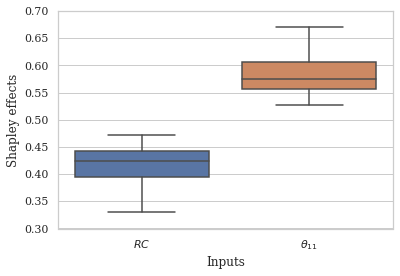

In [52]:
fig, ax = plt.subplots()
sns.set_theme(style='whitegrid')
mpl.rcParams['font.family'] = 'serif'

ax.set(ylim=(0.3, 0.7))
ax = sns.boxplot(x=data_boxplots['input_variable'], y=data_boxplots['shapley_effect'])

ax.set(xlabel='Inputs', ylabel='Shapley effects')

In [53]:
# fig.savefig(fname=os.path.join('figures', f'boxplot_shapley_effects_{n_replicates}'), dpi=1000)

## Shapley Correct Rankings

In [54]:
shapley_indices_all_replicates['correct_ranking'] = shapley_indices_all_replicates['shapley_rc'] < shapley_indices_all_replicates['shapley_theta']

In [55]:
shapley_indices_all_replicates['correct_ranking'].value_counts()

True    100
Name: correct_ranking, dtype: int64

# Morris method

Elementary, Watson.

### Setup for Morris indices
* `params` denotes the mean values of the model inputs
* `cov` denotes the covariance matrix
* 

In [56]:
# Define arguments that stay the same over analysis.
params_df = pd.DataFrame(data=params, columns=['value'])
cov_df = pd.DataFrame(data=cov)
sampling_scheme = 'sobol'
parallel = 'joblib'

model_morris = partial(
    rust_model_morris, trans_probs=trans_probs, 
    init_dict_estimation=init_dict_estimation, demand_dict=demand_dict,
    )

## Morris for one only.
Check that order of indices is correct.

In [57]:
%%time

params_df_names = params_df.copy()
params_df_names.index = ['rc', 'theta']

cov_df_names = cov_df.copy()
cov_df_names.index = ['rc', 'theta']
cov_df_names.rename(columns={0: 'rc', 1: 'theta'}, inplace=True)

n_draws = 100

ee = elementary_effects(
        func=model_morris,
        params=params_df_names,
        cov=cov_df_names,
        n_draws=n_draws,
        sampling_scheme='sobol',
        n_cores=n_cores,
        parallel='joblib',
        seed=1,
    )

Wall time: 3min 39s


In [58]:
%%time

# set_n_draws = np.array([100, 500, 1000]) takes ~ 2h 30min xy s.
# set_n_draws = np.array([1500, 2000]) takes 43min 22s.
# set_n_draws = np.array([2500, 3000]) takes 1h 7min 39s.
set_n_draws = np.array([100, 500, 1000, 1500, 2000, 2500, 3000])

morris_convergence_partial = partial(morris_convergence, model_morris, params_df, cov_df, sampling_scheme, n_cores, parallel)

if run_simulation_morris_indices_convergence is True:
    morris_indices_convergence = list(map(morris_convergence_partial, set_n_draws))
    with open(os.path.join('data', f'morris_indices_convergence_{len(set_n_draws)}_runs_from_{set_n_draws[0]}_to_{set_n_draws[-1]}.pickle'), 'wb') as handle:
        pickle.dump(morris_indices_convergence, handle)
else:
    with open(os.path.join('data', f'morris_indices_convergence_{len(set_n_draws)}_runs_from_{set_n_draws[0]}_to_{set_n_draws[-1]}.pickle'), 'rb') as handle:
        morris_indices_convergence = pickle.load(handle)

Wall time: 32 ms


In [59]:
# set_n_draws = np.array([2500, 3000])
# with open(os.path.join('data', f'morris_indices_convergence_{len(set_n_draws)}_runs_from_{set_n_draws[0]}_to_{set_n_draws[-1]}.pickle'), 'rb') as handle:
#         morris_indices_convergence_2500 = pickle.load(handle)

# set_n_draws = np.array([100, 500, 800, 1000, 2000])
# with open(os.path.join('data', f'morris_indices_convergence_{len(set_n_draws)}_runs_from_{set_n_draws[0]}_to_{set_n_draws[-1]}.pickle'), 'rb') as handle:
#         morris_indices_convergence_100 = pickle.load(handle)

# set_n_draws = np.array([10, 50, 100])
# with open(os.path.join('data', f'morris_indices_convergence_{len(set_n_draws)}_runs_from_{set_n_draws[0]}_to_{set_n_draws[-1]}.pickle'), 'rb') as handle:
#         morris_indices_convergence_10 = pickle.load(handle)

In [60]:
# morris_indices_convergence = morris_indices_convergence_100 + morris_indices_convergence_2500
# set_n_draws = np.array([100, 500, 1000, 1500, 2000, 2500, 3000])
# with open(os.path.join('data', f'morris_indices_convergence_{len(set_n_draws)}_runs_from_{set_n_draws[0]}_to_{set_n_draws[-1]}.pickle'), 'wb') as handle:
#         pickle.dump(morris_indices_convergence, handle)

In [61]:
# For table in tex.
morr_conv_dict = {}
for i in np.arange(len(set_n_draws)):
    morr_conv = pd.concat(
        [pd.concat([pd.Series(morris_indices_convergence[i]['mu_ind'], name=r'$\mu^\ast$'), pd.Series(morris_indices_convergence[i]['sigma_ind'], name=r'$\sigma$'), pd.Series(['independent', 'independent'], name='Type'), pd.Series([r'$RC$', r'$\theta_{11}$'], name='Input')], 
        axis=1), 
        pd.concat([pd.Series(morris_indices_convergence[i]['mu_corr'], name=r'$\mu^\ast$'), pd.Series(morris_indices_convergence[i]['sigma_corr'], name=r'$\sigma$'), pd.Series(['full', 'full'], name='Type'), pd.Series([r'$RC$', r'$\theta_{11}$'], name='Input')], axis=1)])
    
    morr_conv.round(2)
    morr_conv_dict[set_n_draws[i]] = morr_conv.set_index(['Type', 'Input'])
    # Save to tex.
    with open(os.path.join('figures', f'table_morris_conv_{set_n_draws[i]}.tex'),'w') as tf:
        tf.write(morr_conv_dict[set_n_draws[i]].to_latex(escape=False))
        # tf.write(morr_conv.to_latex(escape=False))

In [62]:
# For plotting.
morr_conv_dict = {}
for i in np.arange(len(set_n_draws)):
    morr_conv = pd.concat(
        [pd.concat([pd.Series(morris_indices_convergence[i]['mu_ind'], name='mu'), pd.Series(morris_indices_convergence[i]['sigma_ind'], name='sigma'), pd.Series(['independent', 'independent'], name='Type'), pd.Series(['rc', 'theta'], name='Input')], 
        axis=1), 
        pd.concat([pd.Series(morris_indices_convergence[i]['mu_corr'], name='mu'), pd.Series(morris_indices_convergence[i]['sigma_corr'], name='sigma'), pd.Series(['full', 'full'], name='Type'), pd.Series(['rc', 'theta'], name='Input')], axis=1)])
    morr_conv_dict[set_n_draws[i]] = morr_conv.set_index(['Type', 'Input'])

In [63]:
# rel_morris_diff = {}
# data=np.zeros((len(set_n_draws[:-1]))), 
# rel_morris_diff = pd.DataFrame(columns=set_n_draws[1:], index=pd.MultiIndex.from_arrays([['independent', 'full'], ['mu', 'sigma'], ['theta', 'rc']]))

morris_differences = []
order = []

for t in ['independent', 'full']:
    for var in ['theta', 'rc']:
        for j in ['mu', 'sigma']:

            order.append([t, var, j])
        
        
            for i in np.arange(len(set_n_draws[:-1])):

                delta = morr_conv_dict[set_n_draws[i+1]].loc[(t, var)].loc[j] - morr_conv_dict[set_n_draws[i]].loc[(t, var)].loc[j]

                # sigma_f_theta[i] = (delta / morr_conv_dict[set_n_draws[i]].loc[('full', 'theta')].loc['sigma']) * 100
                # print((delta / morr_conv_dict[set_n_draws[i]].loc[(t, var)].loc[j]) * 100)
                if morr_conv_dict[set_n_draws[i]].loc[(t, var)].loc[j] == 0:
                    # rel_morris_diff.loc[(t, var, j)] = 0
                    morris_differences.append(0)
            
                else:
                    # rel_morris_diff.loc[(t, var, j)] = (delta / morr_conv_dict[set_n_draws[i]].loc[(t, var)].loc[j]) * 100
                    morris_differences.append((delta / morr_conv_dict[set_n_draws[i]].loc[(t, var)].loc[j]) * 100)
                

In [64]:
order_df = pd.DataFrame(order)

In [65]:
morris_differences_df = pd.DataFrame(np.asarray(morris_differences).reshape(8, len(set_n_draws[1:])), index=pd.MultiIndex.from_frame(order_df), columns=set_n_draws[1:])

In [66]:
morris_differences_df

500       1000       1500      2000      2500  \
0           1     2                                                           
independent theta mu      1.808594  0.773662   0.806517  0.135729  0.022424   
                  sigma  17.176551  8.649178  24.698413 -1.860481 -1.657663   
            rc    mu      0.000000  0.000000   0.000000  0.000000  0.000000   
                  sigma   0.000000  0.000000   0.000000  0.000000  0.000000   
full        theta mu     12.577265 -4.627653  -1.211381  1.428294  0.804837   
                  sigma  88.521247 -2.380608   0.210438  0.914024  1.182788   
            rc    mu     -0.962393  0.061364  -0.024504 -0.005852  0.007784   
                  sigma   1.420732  0.177169  -0.095983 -0.007345 -0.031295   

                             3000  
0           1     2                
independent theta mu    -0.009072  
                  sigma -1.871716  
            rc    mu     0.000000  
                  sigma  0.000000  
full        theta mu    -0.720199  
                  sigma -1.149652  
            rc    mu    -0.006238  
                  sigma  0.043691

In [67]:
morris_differences_df_names = morris_differences_df.copy()
morris_differences_df_names.index = [r'$\mu_{\theta_{11}}^{\ast,\ ind}$', r'$\sigma_{\theta_{11}}^{ind}$', r'$\mu_{RC}^{\ast,\ ind}$', r'$\sigma_{RC}^{ind}$', r'$\mu_{\theta_{11}}^{\ast,\ full}$', r'$\sigma_{\theta_{11}}^{full}$', r'$\mu_{RC}^{\ast,\ full}$', r'$\sigma_{RC}^{full}$']

In [68]:
morris_differences_df_names = morris_differences_df_names.round(2)

In [69]:
morris_differences_df_names

,500,1000,1500,2000,2500,3000
"$\mu_{\theta_{11}}^{\ast,\ ind}$",1.81,0.77,0.81,0.14,0.02,-0.01
$\sigma_{\theta_{11}}^{ind}$,17.18,8.65,24.70,-1.86,-1.66,-1.87
"$\mu_{RC}^{\ast,\ ind}$",0.00,0.00,0.00,0.00,0.00,0.00
$\sigma_{RC}^{ind}$,0.00,0.00,0.00,0.00,0.00,0.00
"$\mu_{\theta_{11}}^{\ast,\ full}$",12.58,-4.63,-1.21,1.43,0.80,-0.72
$\sigma_{\theta_{11}}^{full}$,88.52,-2.38,0.21,0.91,1.18,-1.15
"$\mu_{RC}^{\ast,\ full}$",-0.96,0.06,-0.02,-0.01,0.01,-0.01
$\sigma_{RC}^{full}$,1.42,0.18,-0.10,-0.01,-0.03,0.04


In [70]:
# with open(os.path.join('figures', 'morris_convergence_relative_difference.tex'),'w') as tf:
#     tf.write(morris_differences_df_names.to_latex(escape=False)) # escape=False results into correct representation of RC and theta_11.

### Plot convergence of Morris indices
Plot each Morris index ($\mu^{\ast,\ ind}$, $\mu^{\ast,\ full}$, $\sigma^{ind}$, $\sigma^{full}$) against the sample size used to compute them.

In [71]:
# Get dfs for indep and full Morris indices.

columns = ['mu_rc', 'sigma_rc', 'mu_theta', 'sigma_theta', 'n_draws']
# Independent Morris indices.
morris_convergence_independent = pd.DataFrame(data=np.zeros((len(set_n_draws), 5), dtype=np.int32), columns=columns)

for i in np.arange(len(set_n_draws)):
    set_n_draws_i = pd.Series(set_n_draws[i])

    morris_convergence_independent.iloc[i] = pd.concat(
        [
            
            morr_conv_dict[set_n_draws[i]].loc[('independent', 'rc')], 
            morr_conv_dict[set_n_draws[i]].loc[('independent', 'theta')],
            set_n_draws_i
            ],
            axis=0)

morris_convergence_independent.index = set_n_draws

# Full Morris indices.
morris_convergence_full = pd.DataFrame(data=np.zeros((len(set_n_draws), 5), dtype=np.int32), columns=columns)

for i in np.arange(len(set_n_draws)):
    set_n_draws_i = pd.Series(set_n_draws[i])

    morris_convergence_full.iloc[i] = pd.concat(
        [
            
            morr_conv_dict[set_n_draws[i]].loc[('full', 'rc')], 
            morr_conv_dict[set_n_draws[i]].loc[('full', 'theta')],
            set_n_draws_i
            ],
            axis=0)

morris_convergence_full.index = set_n_draws

In [72]:
morris_convergence_independent

,mu_rc,sigma_rc,mu_theta,sigma_theta,n_draws
100,0,0,8.680638,2.881537,100
500,0,0,8.837636,3.376486,500
1000,0,0,8.906009,3.668524,1000
1500,0,0,8.977837,4.574592,1500
2000,0,0,8.990023,4.489482,2000
2500,0,0,8.992039,4.415062,2500
3000,0,0,8.991223,4.332424,3000


In [73]:
morris_convergence_full

,mu_rc,sigma_rc,mu_theta,sigma_theta,n_draws
100,193.619610,69.825364,421.293224,808.934874,100
500,191.756229,70.817395,474.280390,1525.014109,500
1000,191.873898,70.942862,452.332338,1488.709509,1000
1500,191.826881,70.874769,446.852870,1491.842326,1500
2000,191.815655,70.869563,453.235240,1505.478123,2000
2500,191.830585,70.847384,456.883045,1523.284740,2500
3000,191.818620,70.878338,453.592576,1505.772261,3000


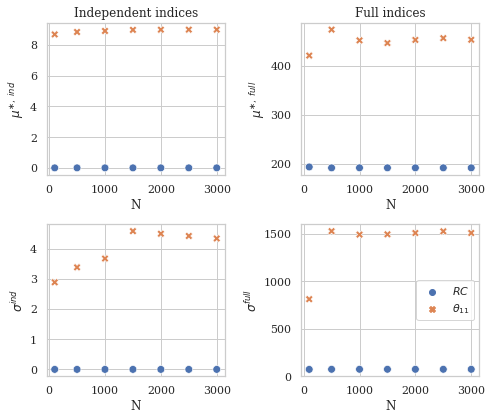

In [74]:
# Plot Morris indices.

plot_size = 6
marker_size = 60
fig, ax = plt.subplots(2, 2, 
sharex=False,
figsize=(7, plot_size)
# figsize=(5, 9)
)
sns.set_theme(style='whitegrid')
mpl.rcParams['font.family'] = 'serif'

ylabel = [r'$\mu^{\ast,\ ind}$', r'$\sigma^{ind}$', r'$\mu^{\ast,\ full}$', r'$\sigma^{full}$']

# Indep. indices.

# mu.
sns.scatterplot(
    data=morris_convergence_independent[['mu_rc', 'mu_theta']],
    markers=['o', 'X'], 
    legend=False, 
    s=marker_size, 
    # color='blue', 
    ax=ax[0, 0]
    )
ax[0, 0].set(xlabel='N', ylabel=ylabel[0], title='Independent indices')

# sigma.
sns.scatterplot(
    data=morris_convergence_independent[['sigma_rc', 'sigma_theta']],
    markers=['o', 'X'], 
    legend=False, 
    s=marker_size, 
    # color='blue', 
    ax=ax[1, 0]
    )
ax[1, 0].set(xlabel='N', ylabel=ylabel[1])

# Full indices.

# mu.
sns.scatterplot(
    data=morris_convergence_full[['mu_rc', 'mu_theta']],
    markers=['o', 'X'], 
    legend=False, 
    s=marker_size, 
    # color='blue', 
    ax=ax[0, 1]
    )
ax[0, 1].set(xlabel='N', ylabel=ylabel[2], title='Full indices')

# sigma.
sigma_full = morris_convergence_full[['sigma_rc', 'sigma_theta']].copy()
sigma_full.columns = [r'$RC$', r'$\theta_{11}$']
sns.scatterplot(
    # data=morris_convergence_full[['sigma_rc', 'sigma_theta']],
    data=sigma_full,
    markers=['o', 'X'], 
    legend=True, 
    s=marker_size, 
    # color='blue', 
    ax=ax[1, 1]
    )

ax[1, 1].set(xlabel='N', ylabel=ylabel[3])

fig.tight_layout()

In [75]:
# fig.savefig(fname=os.path.join('figures', f'morris_convergence'), dpi=1000)

In [76]:
# morr_conv_100_runs_ind = morr_conv_dict[100].copy()

In [77]:
# fig, ax = plt.subplots(1, 2)
# sns.set_theme(style='whitegrid')
# # sns.set_style
# # ax.set(ylim=(0.3, 0.7))

# ax[0].set_xlabel(r"$\mu^{\ast,\ ind}$")
# ax[0].set_ylabel(r"$\sigma^{ind}$")

# ax[1].set_xlabel(r"$\mu^{\ast,\ full}$")
# ax[1].set_ylabel(r"$\sigma^{full}$")

# mpl.rcParams['font.family'] = 'serif'


# sns.scatterplot(x=morr_conv_100_runs_ind.T.loc['$\mu^\ast$'], y=morr_conv_100_runs_ind.T.loc['$\sigma$'], style=morr_conv_100_runs_ind.T.loc['input'], markers=['o', '^'], legend=False, s=100, color='blue', ax=ax[0])
# sns.scatterplot(x=morr_conv_100_runs_full.T.loc['$\mu^\ast$'], y=morr_conv_100_runs_full.T.loc['$\sigma$'], style=morr_conv_100_runs_full.T.loc['input'], markers=['o', '^'], legend=False, s=100, color='blue', ax=ax[1])

# fig.tight_layout()
# fig.show()

In [78]:
# fig, ax = plt.subplots()
# sns.set_theme(style='whitegrid')
# ax = sns.scatterplot(x=morr_conv_100.T.loc['mu'], y=morr_conv_100.T.loc['sigma'], hue=morr_conv_100['type'])

## Morris replicates - $N=27$

In [79]:
%%time

n_draws = 27 # Results into same cost as for Shapley effects (160). Took 44min 32s (100 replicates).
# n_draws=27 and n_replicates_morris=10 took 3min 43s.
# n_draws=100 and n_replicates_morris=10 took 2h 17min 53s.
# Erronously considered n_draws = 160. Took 3h 17min. 52s. But cost of Morris method is 3kN which needs to be 160 in total.

sampling_scheme = 'sobol'
morris_replicate_partial = partial(morris_replicate, model_morris, params_df, cov_df, n_draws, sampling_scheme, n_cores, parallel)

n_replicates_morris = 100

if run_simulation_morris_indices_replicates is True:
    morris_indices_replicates = list(map(morris_replicate_partial, np.arange(n_replicates_morris)+1)) # +1 since in chaospy seed < 1 is interpreted as seed = 1.
    with open(os.path.join('data', f'morris_indices_{n_replicates_morris}_replicates_{n_draws}_draws_{sampling_scheme}.pickle'), 'wb') as handle:
        pickle.dump(morris_indices_replicates, handle)
else:
    with open(os.path.join('data', f'morris_indices_{n_replicates_morris}_replicates_{n_draws}_draws_{sampling_scheme}.pickle'), 'rb') as handle:
        morris_indices_replicates = pickle.load(handle)

Wall time: 449 ms


In [80]:
%%time

n_draws = 100 # 2h 10min 32s

sampling_scheme = 'sobol'
morris_replicate_partial = partial(morris_replicate, model_morris, params_df, cov_df, n_draws, sampling_scheme, n_cores, parallel)

n_replicates_morris = 100

if run_simulation_morris_indices_replicates is True:
    morris_indices_replicates = list(map(morris_replicate_partial, np.arange(n_replicates_morris)+1)) # +1 since in chaospy seed < 1 is interpreted as seed = 1.
    with open(os.path.join('data', f'morris_indices_{n_replicates_morris}_replicates_{n_draws}_draws_{sampling_scheme}.pickle'), 'wb') as handle:
        pickle.dump(morris_indices_replicates, handle)
else:
    with open(os.path.join('data', f'morris_indices_{n_replicates_morris}_replicates_{n_draws}_draws_{sampling_scheme}.pickle'), 'rb') as handle:
        morris_indices_replicates_100 = pickle.load(handle)

Wall time: 385 ms


In [81]:
# run_simulation_morris_indices_replicates = False

In [82]:
%%time

# Different seeds.

n_draws = 100 # 2h 10min 32s

sampling_scheme = 'sobol'
morris_replicate_partial = partial(morris_replicate, model_morris, params_df, cov_df, n_draws, sampling_scheme, n_cores, parallel)

n_replicates_morris = 100

if run_simulation_morris_indices_replicates is True:
    morris_indices_replicates = list(map(morris_replicate_partial, np.arange(n_replicates_morris)+100)) # +1 since in chaospy seed < 1 is interpreted as seed = 1.
    with open(os.path.join('data', f'morris_indices_{n_replicates_morris}_replicates_{n_draws}_draws_{sampling_scheme}_different_seed.pickle'), 'wb') as handle:
        pickle.dump(morris_indices_replicates, handle)
else:
    with open(os.path.join('data', f'morris_indices_{n_replicates_morris}_replicates_{n_draws}_draws_{sampling_scheme}_different_seed.pickle'), 'rb') as handle:
        morris_indices_replicates_100_diff_seed = pickle.load(handle)

Wall time: 531 ms


In [83]:
%%time

n_draws = 200 # 4h 24min 12s

sampling_scheme = 'sobol'
morris_replicate_partial = partial(morris_replicate, model_morris, params_df, cov_df, n_draws, sampling_scheme, n_cores, parallel)

n_replicates_morris = 100

if run_simulation_morris_indices_replicates is True:
    morris_indices_replicates = list(map(morris_replicate_partial, np.arange(n_replicates_morris)+1)) # +1 since in chaospy seed < 1 is interpreted as seed = 1.
    with open(os.path.join('data', f'morris_indices_{n_replicates_morris}_replicates_{n_draws}_draws_{sampling_scheme}.pickle'), 'wb') as handle:
        pickle.dump(morris_indices_replicates, handle)
else:
    with open(os.path.join('data', f'morris_indices_{n_replicates_morris}_replicates_{n_draws}_draws_{sampling_scheme}.pickle'), 'rb') as handle:
        morris_indices_replicates_200 = pickle.load(handle)

Wall time: 326 ms


In [84]:
%%time

n_draws = 500 # 3 h iwas.

sampling_scheme = 'sobol'
morris_replicate_partial = partial(morris_replicate, model_morris, params_df, cov_df, n_draws, sampling_scheme, n_cores, parallel)

n_replicates_morris = 30

if run_simulation_morris_indices_replicates is True:
    morris_indices_replicates = list(map(morris_replicate_partial, np.arange(n_replicates_morris)+1)) # +1 since in chaospy seed < 1 is interpreted as seed = 1.
    with open(os.path.join('data', f'morris_indices_{n_replicates_morris}_replicates_{n_draws}_draws_{sampling_scheme}.pickle'), 'wb') as handle:
        pickle.dump(morris_indices_replicates, handle)
else:
    with open(os.path.join('data', f'morris_indices_{n_replicates_morris}_replicates_{n_draws}_draws_{sampling_scheme}.pickle'), 'rb') as handle:
        morris_indices_replicates_500_30 = pickle.load(handle)

Wall time: 118 ms


In [85]:
%%time

n_draws = 500 # 10h 45min 5s

sampling_scheme = 'sobol'
morris_replicate_partial = partial(morris_replicate, model_morris, params_df, cov_df, n_draws, sampling_scheme, n_cores, parallel)

n_replicates_morris = 100

if run_simulation_morris_indices_replicates is True:
    morris_indices_replicates = list(map(morris_replicate_partial, np.arange(n_replicates_morris)+100)) # +1 since in chaospy seed < 1 is interpreted as seed = 1.
    with open(os.path.join('data', f'morris_indices_{n_replicates_morris}_replicates_{n_draws}_draws_{sampling_scheme}.pickle'), 'wb') as handle:
        pickle.dump(morris_indices_replicates, handle)
else:
    with open(os.path.join('data', f'morris_indices_{n_replicates_morris}_replicates_{n_draws}_draws_{sampling_scheme}.pickle'), 'rb') as handle:
        morris_indices_replicates_500_100 = pickle.load(handle)

Wall time: 407 ms


### Plot Morris replicates (Boxplot)

In [86]:
data_boxplots_morris_independent_mu, data_boxplots_morris_independent_sigma, data_boxplots_morris_full_mu, data_boxplots_morris_full_sigma,morris_indices_all_replicates_27 = get_dataframes_morris_boxplots(morris_indices_replicates)

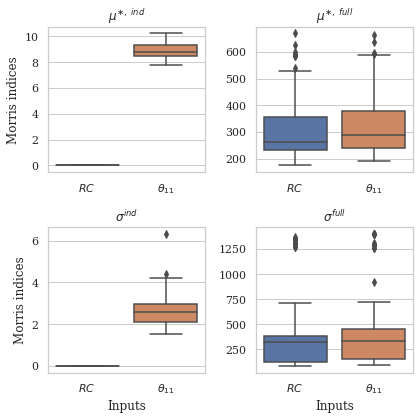

In [87]:
plot_size = 6
fig, ax = plt.subplots(2, 2,
figsize=(plot_size, plot_size)
)
sns.set_theme(style='whitegrid')
mpl.rcParams['font.family'] = 'serif'

ylabel = 'Morris indices'
xlabel = 'Inputs'

# mu ind
sns.boxplot(x=data_boxplots_morris_independent_mu['input_variable'], y=data_boxplots_morris_independent_mu['morris_index'], ax=ax[0, 0])
ax[0, 0].set(title=r'$\mu^{\ast,\ ind}$', ylabel=ylabel, xlabel='')

# sigma ind
sns.boxplot(x=data_boxplots_morris_independent_sigma['input_variable'], y=data_boxplots_morris_independent_sigma['morris_index'], ax=ax[1, 0])
ax[1, 0].set(title=r'$\sigma^{ind}$', ylabel=ylabel, xlabel=xlabel)

#mu full
sns.boxplot(x=data_boxplots_morris_full_mu['input_variable'], y=data_boxplots_morris_full_mu['morris_index'], ax=ax[0, 1])
ax[0, 1].set(title=r'$\mu^{\ast,\ full}$', ylabel='', xlabel='')

# sigma full
sns.boxplot(x=data_boxplots_morris_full_sigma['input_variable'], y=data_boxplots_morris_full_sigma['morris_index'], ax=ax[1, 1])
ax[1, 1].set(title=r'$\sigma^{full}$', xlabel=xlabel, ylabel='')

fig.tight_layout()
# fig.show()

In [88]:
# fig.savefig(fname=os.path.join('figures', f'boxplot_morris_replicates_{n_replicates_morris}_replicates_{n_draws}_draws'), dpi=1000)

# Comparing Shapley effects and Morris indices

Elementary. Compare with respect to convergence, uncertainty at same cost level and 

## Input rankings.

In [89]:
def get_correct_rankings_morris(df):
    # ind.
    df['correct_ranking_mu_ind'] = df['mu_ind_rc'] < df['mu_ind_theta']
    df['correct_ranking_sigma_ind'] = df['sigma_ind_rc'] < df['sigma_ind_theta']

    # full.
    df['correct_ranking_mu_full'] = df['mu_full_rc'] < df['mu_full_theta']
    df['correct_ranking_sigma_full'] = df['sigma_full_rc'] < df['sigma_full_theta']
    df.dropna(inplace=True)
    return df


def get_delta_morris_indices(df):
    # ind.
    df['delta_ranking_mu_ind'] = df['mu_ind_theta'] - df['mu_ind_rc']
    df['delta_ranking_sigma_ind'] = df['sigma_ind_theta'] - df['sigma_ind_rc']

    # full.
    df['delta_ranking_mu_full'] = df['mu_full_theta'] - df['mu_full_rc']
    df['delta_ranking_sigma_full'] = df['sigma_full_theta'] - df['sigma_full_rc']
    df.dropna(inplace=True)
    return df[['delta_ranking_mu_ind', 'delta_ranking_sigma_ind', 'delta_ranking_mu_full', 'delta_ranking_sigma_full']]

In [90]:
morris_indices_all_replicates_no_na_27 = get_correct_rankings_morris(morris_indices_all_replicates_27)

In [91]:
_, _,_, _, morris_indices_all_replicates_100 = get_dataframes_morris_boxplots(morris_indices_replicates_100)

morris_indices_all_replicates_no_na_100 = get_correct_rankings_morris(morris_indices_all_replicates_100)

In [92]:
# Assert that arrays are equal thus asserting that right position in dfs used for extracting Morris indices.
for i in ['mu_ind', 'sigma_ind', 'mu_corr', 'sigma_corr']:
    np.testing.assert_array_almost_equal(ee[i], morris_indices_replicates_100[0][i])

In [93]:
_, _,_, _, morris_indices_all_replicates_200 = get_dataframes_morris_boxplots(morris_indices_replicates_200)

morris_indices_all_replicates_no_na_200 = get_correct_rankings_morris(morris_indices_all_replicates_200)

In [94]:
_, _,_, _, morris_indices_all_replicates_100_diff_seed = get_dataframes_morris_boxplots(morris_indices_replicates_100_diff_seed)

morris_indices_all_replicates_no_na_100_diff_seed = get_correct_rankings_morris(morris_indices_all_replicates_100_diff_seed)

In [95]:
_, _,_, _, morris_indices_all_replicates_500_30 = get_dataframes_morris_boxplots(morris_indices_replicates_500_30)
morris_indices_all_replicates_500_30 = get_correct_rankings_morris(morris_indices_all_replicates_500_30)

In [96]:
np.round_(morris_indices_all_replicates_500_30[['correct_ranking_mu_full']].mean()[0] * 100, 2),

(26.67,)

In [97]:
_, _,_, _, morris_indices_all_replicates_500_100 = get_dataframes_morris_boxplots(morris_indices_replicates_500_100)
morris_indices_all_replicates_500_100_no_na = get_correct_rankings_morris(morris_indices_all_replicates_500_100)

In [98]:
np.round_(morris_indices_all_replicates_500_100_no_na[['correct_ranking_mu_full']].mean()[0] * 100, 2),

(25.0,)

In [99]:
morris_indices_all_replicates_500_100_delta = get_delta_morris_indices(morris_indices_all_replicates_500_100)

In [100]:
morris_indices_all_replicates_500_100_delta

,delta_ranking_mu_ind,delta_ranking_sigma_ind,delta_ranking_mu_full,delta_ranking_sigma_full
0,8.945594,2.488809,-10.024554,3.263433
1,8.921484,3.665971,274.107397,1423.624268
2,9.495211,11.610272,-7.020540,-70.256282
3,8.853329,3.039178,-252.130221,-1295.644484
4,8.939795,2.484064,-9.360431,2.782456
...,...,...,...,...
95,8.844482,2.972753,-238.118209,-1256.666763
96,8.900972,2.416674,-9.634438,2.670876
97,8.936725,3.645131,263.627117,1392.940274
98,9.504051,11.636449,-11.055791,-77.360475


In [101]:
morris_indices_all_replicates_500_100_delta['delta_ranking_mu_full'].sort_values()

67   -256.022816
35   -254.998940
71   -254.995803
27   -254.770264
75   -254.674671
         ...    
61    279.374348
57    279.801150
73    280.081147
69    280.326193
65    280.829511
Name: delta_ranking_mu_full, Length: 100, dtype: float64

Seed attached to largest difference between indices for $RC$ and $\theta_{11}$, where $RC$ is assessed "more important" than $\theta_{11}$ is 67.
Use this seed for the computation of Morris indices with a large sample size: $N=3\,000$.

In [102]:
%%time

# 1h 4min 26s

if run_morris_3000 is True:

    seed=67

    params_df_names = params_df.copy()
    params_df_names.index = ['rc', 'theta']

    cov_df_names = cov_df.copy()
    cov_df_names.index = ['rc', 'theta']
    cov_df_names.rename(columns={0: 'rc', 1: 'theta'}, inplace=True)

    n_draws = 3000

    ee_3000_seed_67 = elementary_effects(
            func=model_morris,
            params=params_df_names,
            cov=cov_df_names,
            n_draws=n_draws,
            sampling_scheme='sobol',
            n_cores=n_cores,
            parallel='joblib',
            seed=seed,
        )
    with open(os.path.join('data', f'morris_indices_3000_seed_67.pickle'), 'wb') as handle:
        pickle.dump(ee_3000_seed_67, handle)
else:
    with open(os.path.join('data', f'morris_indices_3000_seed_67.pickle'), 'rb') as handle:
        ee_3000_seed_67 = pickle.load(handle)



Wall time: 13 ms


In [103]:
ee_3000_seed_67

{'mu_ind': rc       0.000000
 theta    8.844684
 dtype: float64,
 'mu_corr': rc       444.468897
 theta    203.702777
 dtype: float64,
 'sigma_ind': rc       0.000000
 theta    3.095897
 dtype: float64,
 'sigma_corr': rc       1405.577913
 theta      69.700540
 dtype: float64,
 'mu_ind_cum':        rc     theta
 1     NaN       NaN
 2     0.0  8.252583
 3     0.0  7.697218
 4     0.0  8.104061
 5     0.0  7.869233
 ...   ...       ...
 2996  0.0  8.845710
 2997  0.0  8.845022
 2998  0.0  8.844081
 2999  0.0  8.844934
 3000  0.0  8.844684
 
 [3000 rows x 2 columns],
 'mu_corr_cum':               rc       theta
 1            NaN         NaN
 2     113.655477  169.504747
 3     131.480594  196.078113
 4     131.861377  170.455739
 5     126.973610  185.106071
 ...          ...         ...
 2996  444.798967  203.670321
 2997  444.800814  203.688122
 2998  444.676943  203.692783
 2999  444.588328  203.694477
 3000  444.468897  203.702777
 
 [3000 rows x 2 columns],
 'sigma_ind_cum':        

<AxesSubplot:ylabel='delta_ranking_mu_full'>

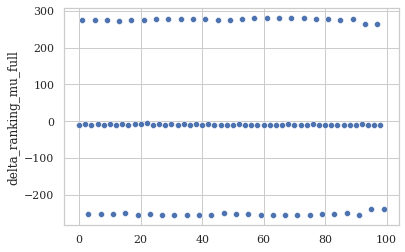

In [104]:
fig, ax = plt.subplots()
sns.scatterplot(data=morris_indices_all_replicates_500_100_delta['delta_ranking_mu_full'])

In [105]:
# with open(os.path.join('data', f'morris_indices_100_replicates_160_draws.pickle'), 'rb') as handle:
#         morris_indices_replicates_160_draws_random = pickle.load(handle)
# data_boxplots_morris_independent_mu_160, data_boxplots_morris_independent_sigma_160, data_boxplots_morris_full_mu_160, data_boxplots_morris_full_sigma_160, morris_indices_all_replicates_160 = get_dataframes_morris_boxplots(morris_indices_replicates_160_draws_random)

# morris_indices_all_replicates_no_na_160 = get_correct_rankings_morris(morris_indices_all_replicates_160)
# print(np.round_(morris_indices_all_replicates_no_na_160[['correct_ranking_mu_ind']].mean()[0] * 100, 2),
# np.round_(morris_indices_all_replicates_no_na_160[['correct_ranking_mu_full']].mean()[0] * 100, 2))

In [106]:
np.round_(morris_indices_all_replicates_no_na_100_diff_seed[['correct_ranking_mu_ind']].mean()[0] * 100, 2),

(100.0,)

In [107]:
np.round_(morris_indices_all_replicates_no_na_100_diff_seed[['correct_ranking_mu_full']].mean()[0] * 100, 2),

(38.0,)

In [108]:
correct_rankings = pd.DataFrame({'Measure': ['Shapley effects', 'Morris indices', 'Morris indices', 'Morris indices', 'Morris indices', 'Morris indices', 'Morris indices'],
'Comp. cost': [160, 162, 162, 600, 600, 1200, 1200],
'Type': ['-', 'independent', 'full', 'independent', 'full', 'independent', 'full'],
'Accuracy': [np.round_(shapley_indices_all_replicates['correct_ranking'].mean() * 100, 2), 
np.round_(morris_indices_all_replicates_no_na_27[['correct_ranking_mu_ind']].mean()[0] * 100, 2),
np.round_(morris_indices_all_replicates_no_na_27[['correct_ranking_mu_full']].mean()[0] * 100, 2),
np.round_(morris_indices_all_replicates_no_na_100[['correct_ranking_mu_ind']].mean()[0] * 100, 2),
np.round_(morris_indices_all_replicates_no_na_100[['correct_ranking_mu_full']].mean()[0] * 100, 2),
np.round_(morris_indices_all_replicates_no_na_200[['correct_ranking_mu_ind']].mean()[0] * 100, 2),
np.round_(morris_indices_all_replicates_no_na_200[['correct_ranking_mu_full']].mean()[0] * 100, 2),
]})

In [109]:
correct_rankings.index = pd.MultiIndex.from_frame(correct_rankings[['Measure', 'Comp. cost']])
correct_rankings.drop(['Measure', 'Comp. cost'], axis=1, inplace=True)

In [110]:
correct_rankings

Type  Accuracy
Measure         Comp. cost                       
Shapley effects 160                   -    100.00
Morris indices  162         independent    100.00
                162                full     59.14
                600         independent    100.00
                600                full     34.00
                1200        independent    100.00
                1200               full     27.00

In [111]:
# with open(os.path.join('figures', 'correct_rankings.tex'),'w') as tf:
#     tf.write(correct_rankings.to_latex(escape=False)) # escape=False results into correct representation of RC and theta_11.

In [112]:
# get_dataframes_morris_boxplots(morris_indices_replicates_200)

## Simple model: Uncertainty and convergence in Morris indices.

In [113]:
def get_share_correct_ranking(eoq_morris_indices_replicates):
    _, _,_, _, eoq_morris_indices_all_replicates_100 = get_dataframes_morris_boxplots(eoq_morris_indices_replicates)
    eoq_morris_indices_all_replicates_100 = get_correct_rankings_morris(eoq_morris_indices_all_replicates_100)
    return np.round_(eoq_morris_indices_all_replicates_100[['correct_ranking_mu_full']].mean()[0] * 100, 2),

In [114]:
def eoq_model_morris(x):
    """EOQ Model that handles data as presented by elementary_effects."""

    r=0.1

    m = x["value"][0]
    c = x["value"][1]
    s = x["value"][2]
    # m_below_zero = 0
    if m < 0:
        m = 0
        # print('m < 0')
    elif c < 0:
        raise ValueError
    elif s < 0:
        s = 0
        # print('s < 0')
    else:
        pass

    return np.sqrt((24 * m * s) / (r * c))

In [115]:
run_eoq_model_replicates = False

In [116]:
# %%time

# params_eoq = pd.DataFrame(data=[5.345, 0.0135, 2.15], columns=["value"])
# cov_eoq = pd.DataFrame(data=np.diag([1, 0.000001, 0.01]))

# n_draws = 100 # 4min 5s.

# sampling_scheme = 'sobol'
# eoq_morris_replicate_partial = partial(morris_replicate, eoq_model_morris, params_eoq, cov_eoq, n_draws, sampling_scheme, n_cores, parallel)

# n_replicates_morris = 100

# if run_eoq_model_replicates is True:
#     eoq_morris_indices_replicates = list(map(eoq_morris_replicate_partial, np.arange(n_replicates_morris)+100)) # +1 since in chaospy seed < 1 is interpreted as seed = 1.
# #     with open(os.path.join('data', f'morris_indices_{n_replicates_morris}_replicates_{n_draws}_draws_{sampling_scheme}.pickle'), 'wb') as handle:
# #         pickle.dump(morris_indices_replicates, handle)
# # else:
# #     with open(os.path.join('data', f'morris_indices_{n_replicates_morris}_replicates_{n_draws}_draws_{sampling_scheme}.pickle'), 'rb') as handle:
# #         morris_indices_replicates_500_100 = pickle.load(handle)

In [117]:
# get_share_correct_ranking(eoq_morris_indices_replicates)

In [118]:
# %%time

# params_eoq = pd.DataFrame(data=[5.345, 0.0135, 2.15], columns=["value"])
# cov_eoq = pd.DataFrame(data=np.diag([1, 0.000001, 0.01]))

# n_draws = 200 # 4min 5s.

# sampling_scheme = 'sobol'
# eoq_morris_replicate_partial = partial(morris_replicate, eoq_model_morris, params_eoq, cov_eoq, n_draws, sampling_scheme, n_cores, parallel)

# n_replicates_morris = 100

# if run_eoq_model_replicates is True:
#     eoq_morris_indices_replicates_200 = list(map(eoq_morris_replicate_partial, np.arange(n_replicates_morris)+100)) # +1 since in chaospy seed < 1 

In [119]:
# get_share_correct_ranking(eoq_morris_indices_replicates_200)

In [120]:
# %%time

# params_eoq = pd.DataFrame(data=[5.345, 0.0135, 2.15], columns=["value"])
# cov_eoq = pd.DataFrame(data=np.diag([1, 0.000001, 0.01]))

# n_draws = 500 # 14min 22s.

# sampling_scheme = 'sobol'
# eoq_morris_replicate_partial = partial(morris_replicate, eoq_model_morris, params_eoq, cov_eoq, n_draws, sampling_scheme, n_cores, parallel)

# n_replicates_morris = 100

# if run_eoq_model_replicates is True:
#     eoq_morris_indices_replicates_500 = list(map(eoq_morris_replicate_partial, np.arange(n_replicates_morris)+100)) # +1 since in chaospy seed < 1 

In [121]:
# get_share_correct_ranking(eoq_morris_indices_replicates_500)

In [122]:
# %%time

# params_eoq = pd.DataFrame(data=[5.345, 0.0135, 2.15], columns=["value"])
# cov_eoq = pd.DataFrame(data=np.diag([1, 0.000001, 0.01]))

# n_draws = 1000 # 34min 4s

# sampling_scheme = 'sobol'
# eoq_morris_replicate_partial = partial(morris_replicate, eoq_model_morris, params_eoq, cov_eoq, n_draws, sampling_scheme, n_cores, parallel)

# n_replicates_morris = 100

# if run_eoq_model_replicates is True:
#     eoq_morris_indices_replicates_1000 = list(map(eoq_morris_replicate_partial, np.arange(n_replicates_morris)+100)) # +1 since in chaospy seed < 1 

In [124]:
# get_share_correct_ranking(eoq_morris_indices_replicates_1000)

## Computational cost

In [125]:
def computational_cost_shapley(n_inputs, n_variance, n_outer, n_inner):
    
    return n_variance + np.math.factorial(n_inputs) * n_outer * n_inner * (n_inputs - 1)

def comutational_cost_morris(n_inputs, n_draws):
    return 3 * n_inputs * n_draws

In [126]:
computational_cost_df = pd.DataFrame(data=np.arange(10 ** 3), columns=['N'])
n_inputs_df = 2
n_variance_df = 1000
n_inner_df = 3
computational_cost_df['Shapley'] = computational_cost_shapley(n_inputs_df, n_variance_df, computational_cost_df['N'], n_inner_df)
computational_cost_df['Morris'] = comutational_cost_morris(n_inputs_df, computational_cost_df['N'])

In [127]:
computational_cost_df

,N,Shapley,Morris
0,0,1000,0
1,1,1006,6
2,2,1012,12
3,3,1018,18
4,4,1024,24
...,...,...,...
995,995,6970,5970
996,996,6976,5976
997,997,6982,5982
998,998,6988,5988


<AxesSubplot:>

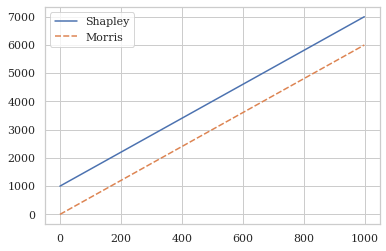

In [128]:
fig, ax = plt.subplots()

# sns.relplot(x=computational_cost_df['N'], y=computational_cost_df['Shapley'], kind='line')
# sns.lineplot(x=computational_cost_df['N'], y=computational_cost_df['Shapley'])
sns.lineplot(data=computational_cost_df[['Shapley', 'Morris']])
# sns.relplot(x=computational_cost_df['N'], y=computational_cost_df['Morris'], )

# References
 - ruspy
 - econsa